In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Setup a SparkSession
spark = SparkSession.builder.config("spark.rpc.message.maxSize",1024).getOrCreate()

In [3]:
# Training sample
data = pd.read_csv('training.csv')
data = data.drop('timestamp',axis=1)

# Test sample
data_requests = pd.read_csv('requests.csv')
data_requests_spark = spark.createDataFrame(data_requests)

# Users metadata
usersdb = pd.read_csv('users.dat',sep='::',header=None,names=['UserID','Gender','Age','Occupation','Zip-code'])
usersdb = pd.get_dummies(usersdb, columns=['Gender'], drop_first=True)

/home/hadoop/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Looking at our training data, we saw much of the user data is very sparse, and to make the predictions better, we thought we could use KMeans clustering to group the users together by some demographic information

In [57]:
usersdb.iloc[0:10,:]

,UserID,Age,Occupation,Zip-code,Gender_M
0,1,1,10,48067,0
1,2,56,16,70072,1
2,3,25,15,55117,1
3,4,45,7,02460,1
4,5,25,20,55455,1
5,6,50,9,55117,0
6,7,35,1,06810,1
7,8,25,12,11413,1
8,9,25,17,61614,1
9,10,35,1,95370,0


I think the most telling demographic information is age and gender (at least to start our basic model), and after some testing, we found that 4 clusters got us the best results in the silhouette score.

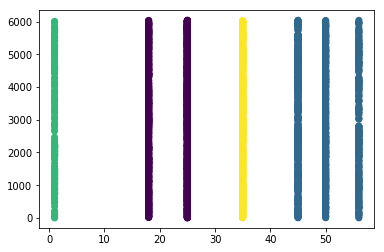

In [45]:
#Kmeans clustering
dataKmeans = usersdb[['Age','Gender_M']]
kmeans_model = KMeans(n_clusters=4, n_init = 10, max_iter =100, random_state=1).fit(dataKmeans)
labels=kmeans_model.labels_
silhouette_score(dataKmeans, labels, metric='euclidean') #0.76
plt.scatter(dataKmeans.iloc[:,0],usersdb.iloc[:,0],c=labels)

In [46]:
silhouette_score(dataKmeans, labels, metric='euclidean') #0.76

0.7652377651028343

In [9]:
labels=kmeans_model.labels_

In [10]:
labels

array([2, 1, 0, ..., 1, 1, 0], dtype=int32)

In [11]:
#Joining kmeans labels and data matrix on user id
data_matrix_pd = pd.pivot_table(data, values='rating', index=['user'], columns=['movie'], aggfunc=np.mean)
data_matrix_pd['index1'] = data_matrix_pd.index

As you can see below, this is an extremely sparse matrix.  We could fill in the values for all the means of each column, but we decided to cluster the users first, and fill in the values using the means of each cluster, thinking that would get us better results.

In [12]:
data_matrix_pd.iloc[0:5,:]

movie,1,2,3,4,5,6,7,8,9,10,...,3944,3945,3946,3947,3948,3949,3950,3951,3952,index1
user,,,,,,,,,,,,,,,,,,,,,
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,636
637,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,637
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,638
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639
640,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640


In [13]:
labels=pd.DataFrame(labels)
labels['index1'] = labels.index+1

data_matrix_merged=pd.merge(labels, data_matrix_pd, on='index1',how='outer')
data_matrix_merged=data_matrix_merged.sort_values(by=['index1'])
data_matrix_merged=data_matrix_merged.set_index('index1')
data_matrix_merged.rename(columns ={0: 'label'}, inplace =True)

In [14]:
data_matrix_merged.iloc[0:5,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Filling in missing values with average of ratings given to a movie by users in that cluster
data_matrix_merged1 = pd.read_csv('data_matrix_new.csv')
data_matrix_merged1 = data_matrix_merged1.set_index('index1')
cols=data_matrix_merged.columns
data_matrix_merged1.columns = cols
data_matrix_merged = data_matrix_merged1

In [21]:
data_matrix_merged.iloc[0:5,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,3.860215,3.300000,3.307692,3.333333,3.461538,3.769231,3.461538,2.833333,2.666667,...,2.500000,1.0,2.000000,2.333333,NaN,4.166667,5.000000,3.0,NaN,3.777778
2,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.0,4.000000
3,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353
4,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.0,4.000000
5,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.4,3.482353


In [22]:
#There are still some missing values, fill them in with column means (total average rating of a movie)
#data_matrix_pd_fillna = data_matrix_pd.fillna(data['rating'].mean())
for j in range(data_matrix_merged.shape[1]):
    data_matrix_merged.iloc[:,j]=data_matrix_merged.iloc[:,j].fillna(data_matrix_merged.iloc[:,j].mean())

In [23]:
data_matrix_merged.iloc[0:5,:]

,label,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
index1,,,,,,,,,,,,,,,,,,,,,
1,2,3.860215,3.300000,3.307692,3.333333,3.461538,3.769231,3.461538,2.833333,2.666667,...,2.500000,1.0,2.000000,2.333333,3.341516,4.166667,5.000000,3.0,3.711157,3.777778
2,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.000000,4.000000
3,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.400000,3.482353
4,1,4.054688,3.355556,2.974026,3.052632,3.028571,3.586538,3.506667,2.857143,3.000000,...,2.714286,5.0,2.000000,2.500000,3.400000,3.437500,4.000000,3.6,4.000000,4.000000
5,0,4.138595,3.088685,3.039823,2.615385,2.881119,3.955140,3.378947,2.793103,2.592593,...,2.615385,1.0,1.277778,2.375000,3.666667,3.731801,4.377778,2.5,3.400000,3.482353


In [24]:
#Convert the wide matrix into long format for ALS model
data_matrix_merged = data_matrix_merged.drop('label',axis=1)
data_matrix_long=data_matrix_merged.unstack().reset_index()
data_matrix_long.rename(columns ={'level_0': 'movie','index1': 'user',0: 'rating'}, inplace =True)

In [25]:
data_matrix_long.iloc[0:5,:]

,movie,user,rating
0,1,1,3.860215
1,1,2,4.054688
2,1,3,4.138595
3,1,4,4.054688
4,1,5,4.138595


In [26]:
spark_df = spark.createDataFrame(data_matrix_long) 

In [29]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [28]:
spark_df.cache()

DataFrame[movie: bigint, user: bigint, rating: double]

Caching the new dataframe to memory, as it will perform better (run faster)

In [50]:
# Create an untrained ALS model.
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    regParam = 0.1,
    nonnegative=True) 

In [48]:
spark_df = spark.read.csv('data_matrix_long.csv',header=True,inferSchema=True)

In [49]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [51]:
recommender = als_model.fit(train)

In [52]:
##Add predictions
train_tr = recommender.transform(train)
test_tr = recommender.transform(test)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating",metricName="rmse")

rmse_train=evaluator.evaluate(train_tr)
rmse_test=evaluator.evaluate(test_tr)

In [53]:
rmse_train

0.2958990485296767

In [54]:
rmse_test

0.2959125836679897

We believe these are pretty good train and test scores, as they are pretty close, but let's implement a grid search, to look over the parameters of our model, to see if we can tune our hyperparameters, and squeeze out better performance for our model.

In [56]:
#Grid search
param_grid = ParamGridBuilder()\
                .addGrid(als_model.rank, [5, 10, 15, 20])\
                .addGrid(als_model.maxIter, [1, 2, 3, 4, 5])\
                .addGrid(als_model.regParam, [0.05, 0.1, 0.15, 0.2])\
                .build()

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating",metricName="rmse")

tvs = TrainValidationSplit(
        estimator = als_model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator)

model = tvs.fit(train)
best_model = model.bestModel

In [61]:
train_tr = best_model.transform(train)
test_tr = best_model.transform(test)

In [62]:
rmse_train=evaluator.evaluate(train_tr)
rmse_test=evaluator.evaluate(test_tr)
print(best_model.rank)
print(best_model._java_obj.parent().getMaxIter())
print(best_model._java_obj.parent().getRegParam())

5
5
0.05


In [63]:
rmse_train

0.2911126805085439

In [64]:
rmse_test

0.2917141254511486

It looks like our model would have done better, if our hyperparameters had these values, so we will change these to match our grid search's findings.

In [65]:
# Create final model.
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    regParam = 0.05,
    rank = 5,
    maxIter = 5,
    nonnegative=True) 

In [66]:
recommender = als_model.fit(spark_df)

In [68]:
data_requests_spark_tr = recommender.transform(data_requests_spark)

In [72]:
data_requests_spark_tr.take(5)

[Row(user=5333, movie=148, prediction=2.7842154502868652),
 Row(user=840, movie=148, prediction=2.7613234519958496),
 Row(user=216, movie=148, prediction=2.7925286293029785),
 Row(user=482, movie=148, prediction=2.7580721378326416),
 Row(user=752, movie=148, prediction=2.685802698135376)]

In [82]:
data_requests_spark_pd = data_requests_spark_tr.toPandas()
data_requests_spark_pd.rename(columns={'prediction':'rating'}, inplace=True)

In [85]:
data_requests_spark_pd = data_requests_spark_pd.fillna(data_matrix_long['rating'].mean())

In [87]:
data_requests_spark_pd.to_csv('submission.csv',columns=["user","movie","rating"], index=False)

After our ratings predictions got checked against the hidden user data set, to see well our model performed, we got score=4.27985347985348, which was the highest in class.

We were ultimately looking at the top 5% of the movies ratings of the hidden data set, because our recommender system would only be recommending movies that the user would like, and thus likely to give a high score, and so our 4.28 predicted rating is close to what we would look for and feel confident in our recommending selection to a given user

WHAT TO DO NEXT

#1 . Cluster based on the movie data folder we were given.  We ultimately thought that the movie data clustering would be a better predictor than the user data information, but given time constraints, user data was much simpler, and we still had to overcome problems of populating an extremely sparse matrix.
#2.  Use the user metadata directly from the website, to find out more and ultimately cluster based on that.  We could use NLP techniques to find out which movies are similar, then use a clustering technique, and ultimately we think this would have generated the best model, but we found out quickly, the meta data wasn't formatted optimally to go down this path.